# Time Series Modeling

Aaron Balke

S# 011005116

# Presentation

https://youtu.be/lgKD4ZgVzOU

# Part I: Research Question

## A1. Question

My research question for this assessment is, "Using the provided dataset, can we accurately forecast 6 months of data?".

## A2. Goals

The goal is to predict the final six months of data using the previous data to train our ARIMA model that accounts for seasonal, trend, and residual components. We hope to have a model with an RMSE value of less than 5. This would mean our model is accurate within 5 million dollars on average.

# Part II: Method Justification

## B. Assumptions

Stationary: For accurate modeling, there cannot be trends or seasonality. Mean, Variance, and Autocorrelation have to be Time-Invariant (Fulton). Time-series modeling requires trends, seasonality, and residuals to be "decomposed" from one another to accurately fit and predict future values.
Autocorrelation: Autocorrelation is the coefficient of correlation between two values in a time series. Autocorrelation occurs when the residuals are not independent of each other (Statistics Solutions), we require little or no autocorrelation for accurate modeling.

# Part III: Data Preparation
## C1. Visualization

In [1]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Statsmodels Imports for TS Analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Sklearn Import for Evaluation Metrics
from sklearn.metrics import mean_squared_error

# pmdarima Required to Automate Arima model choosing
!pip install pmdarima
from pmdarima import auto_arima

# Import Data
df = pd.read_csv('../medical_time_series .csv')

In [2]:
# Preparer Time Data: Replace Incrementing Value with Data Type DateTime
start_date = pd.to_datetime("2020-01-01")
df["Date"] = start_date + (df["Day"] - 1).astype('timedelta64[D]')
df.drop('Day', axis=1, inplace=True)

# Set Date as index, Helps Automate Time-Series Plotting
df.set_index("Date", inplace=True)

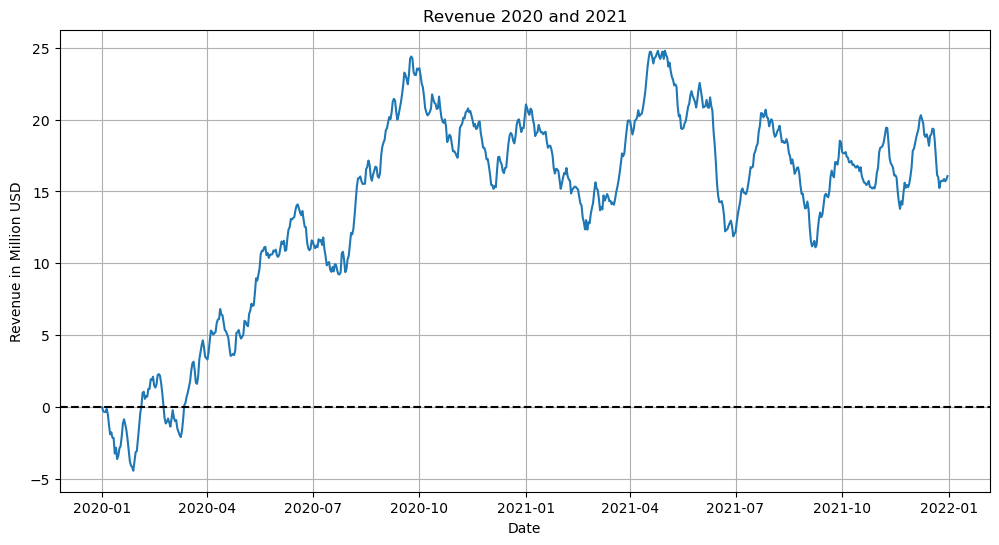

In [3]:
# Plot Revenue Data
plt.figure(figsize=(12,6))
plt.plot(df)
plt.grid()
plt.axhline(0, color="black", linestyle="--")
plt.title("Revenue 2020 and 2021")
plt.xlabel("Date")
plt.ylabel("Revenue in Million USD")
plt.show()

## C2. Time Step Information

The Time-Series data was provided as an incrementing day counter, I changed it to a datetime value. For analysis, our step is a day, and our total number of steps is 731 Days (2 Years). There are no missing values or gaps in the time data.

## C3. Stationary

We can see from the above graph there is a trend, to confirm the data is not stationary we can use the Dickey-Fuller Test. A Dickey Fuller p-value greater than alpha (0.05) means the data is not stationary.

In [4]:
# Dickey Fuller Test (Checks for Trends)
pval = adfuller(df['Revenue'])[1]
print(f'P-Value of Observed Data: {pval.round(4)}')

df_diff = df.diff().dropna()

P-Value of Observed Data: 0.1997


We can see the observed data has a p-value > 0.05, so at this time we would get the difference of the values (df. diff().dropna()) and run an analysis on that. However, since our ARIMA model will have this option built-in we do not need to take action right now. The only thing this changes is the d value in ARIMA (p, d, q) will be one more than if we used a difference dataframe. 

## C4. Data Preparation

The biggest piece of preparation for our analysis has already taken place, the converting of a day count into a datetime format, and setting that feature as our index will make time-series analysis a lot easier since statsmodels can remove a lot of the hassle. The only step left is to create a test and training split. Instead of using sklearn train_test_split, I will directly choose dates to split on, this is much easier in my opinion. I chose a 75/25 split because it would be easier to visualize and organize. The Training size is simply 1.5 Years, the testing is 0.5 Years.

After the split, I will plot it to confirm accuracy.

In [5]:
# Train & Test Split 75% 25%
df_train = df[:'2021-06-30']
df_test = df['2021-07-01':]

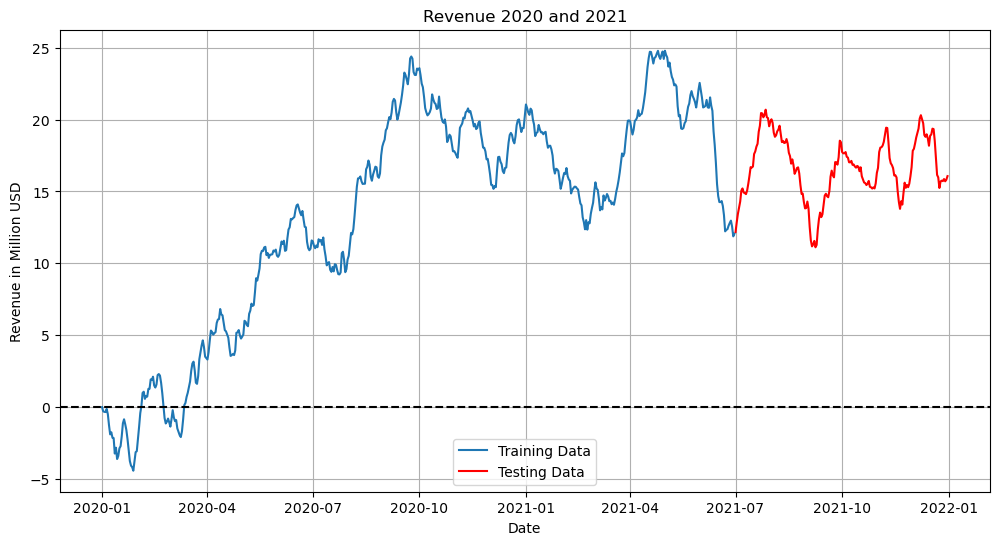

In [6]:
# Plot Train and Test Split Revenue Data
plt.figure(figsize=(12,6))
plt.plot(df_train, label="Training Data")
plt.plot(df_test, color='red', label="Testing Data")
plt.grid()
plt.axhline(0, color="black", linestyle="--")
plt.title("Revenue 2020 and 2021")
plt.xlabel("Date")
plt.ylabel("Revenue in Million USD")
plt.legend(loc="lower center")
plt.show()

## C5. Export Data

In [7]:
# Export Data
df_train.to_csv('d213_task1_train.csv')
df_test.to_csv('d213_task1_test.csv')

# Part IV: Model Identification and Analysis

## D1. Visual Findings

The following visualizations have been running on the total nonstationary data. So we can already assume a trend will exist.

### Seasonal Component

1. We will get the seasonal component from the decomposition.
2. To evaluate the seasonal components period/cycle, we will run autocorrelation on the on the seasonal component. The distance between where the correlation coefficient reaches ~1.00 is the cycle length. In our case, this is weekly (7 days)

In [8]:
# Decompose Training Data
decomp_results = seasonal_decompose(df)

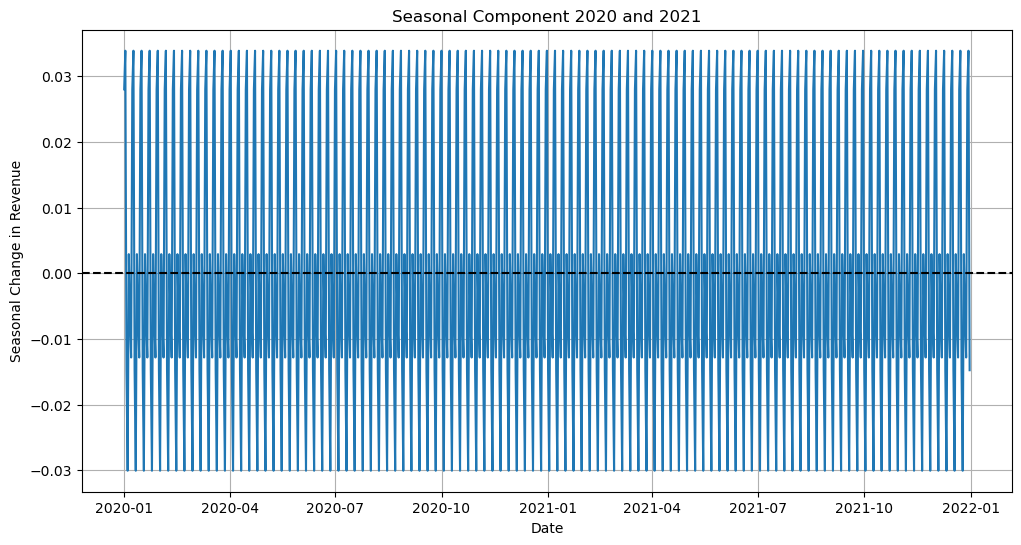

In [9]:
# Plot Seasonal Component
plt.figure(figsize=(12,6))
plt.plot(decomp_results.seasonal)
plt.grid()
plt.axhline(0, color="black", linestyle="--")
plt.title("Seasonal Component 2020 and 2021")
plt.xlabel("Date")
plt.ylabel("Seasonal Change in Revenue")
plt.show()

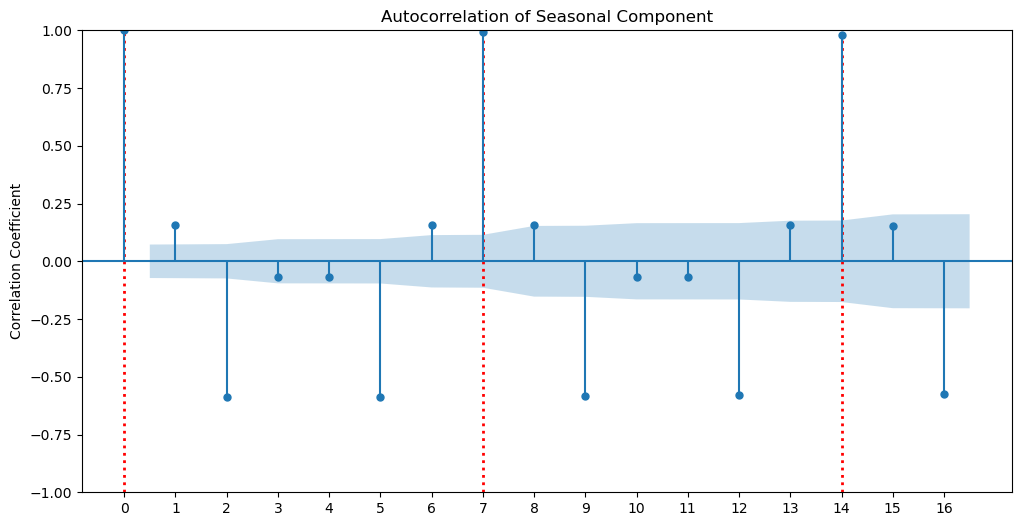

In [10]:
# Get Seasonal Period, Every AutoCorr Value 1.0 is a new period
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.set_ylabel("Correlation Coefficient")
ax.axvline(0, color='red', linestyle=":", linewidth=2)
ax.axvline(7, color='red', linestyle=":", linewidth=2)
ax.axvline(14, color='red', linestyle=":", linewidth=2)
fig = plot_acf(decomp_results.seasonal, lags=16, title="Autocorrelation of Seasonal Component", ax=ax)
ax.set_xticks(np.arange(0, 17, 1.0))
plt.show()

### Trend

A Trend line is visible, this is expected since we are running the decomposition on the original dataset, which we saw was not stationary. Using the ARIMA model we will remove this trend for analysis.

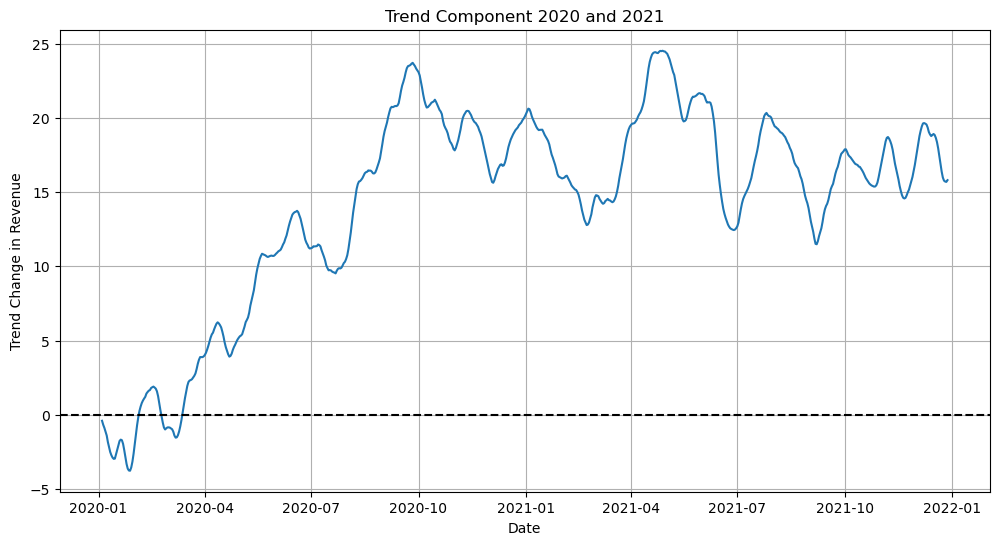

In [11]:
# Plot Trend Component

plt.figure(figsize=(12,6))
plt.plot(decomp_results.trend)
plt.grid()
plt.axhline(0, color="black", linestyle="--")
plt.title("Trend Component 2020 and 2021")
plt.xlabel("Date")
plt.ylabel("Trend Change in Revenue")
plt.show()

### Autocorrelation

Autocorrelation and Partial Autocorrelation are used to help us choose the most effective model. Below is a quick chart to explain how to choose a model.

|      | AR           | MA           | ARMA  |
|:-----|:-------------|:-------------|:------|
| ACF  | Tails        | Cuts off (q) | Tails |
| PACF | Cuts off (p) | Tails        | Tails |

Based on the above plots, ACF Tails off, and PACF Cuts off at 1. This means we have an AR(1) model or ARIMA(1,1,0) model. Later I will use auto_arima to verify this and take into account the seasonal component.

C:\Users\Aaron\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


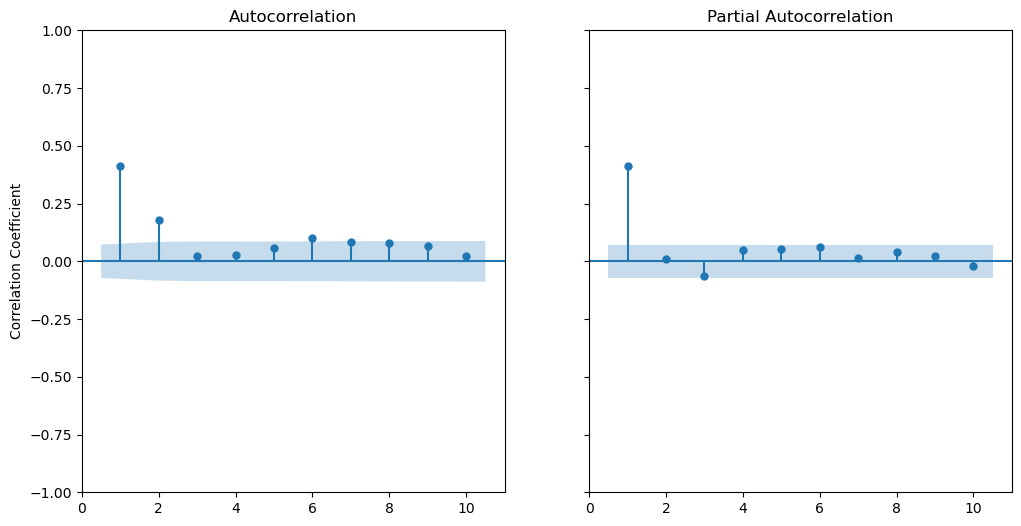

In [12]:
# Check Autocorr and Partial Autocorr to see if AR, MA, or ARMA model
fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(12,6))
ax1.set_ylabel("Correlation Coefficient")
plot_acf(df_diff, lags=10, zero=False, ax=ax1)
plot_pacf(df_diff, lags=10, zero=False, ax=ax2)
plt.show()

### Spectral Density

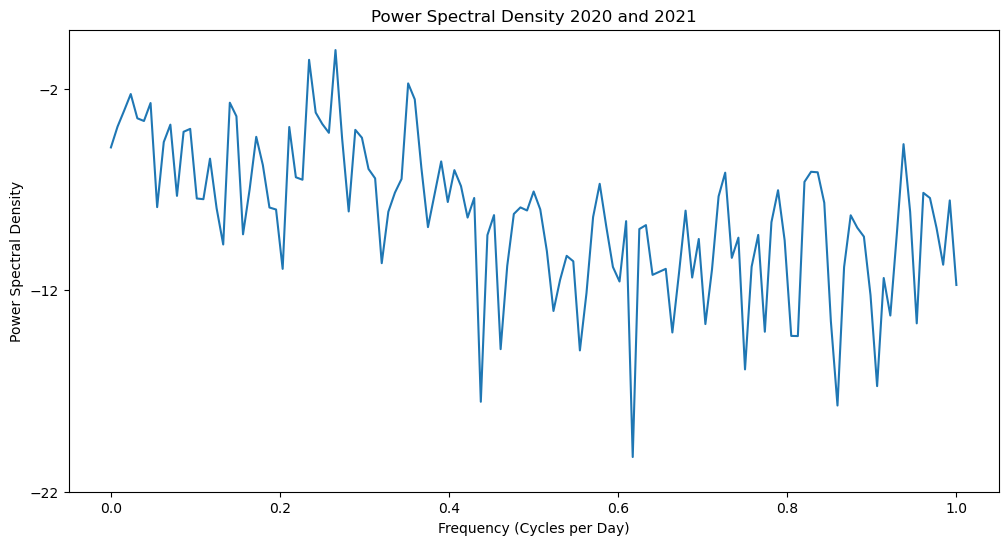

In [13]:
# Plot Spectral Density
plt.figure(figsize=(12,6))
plt.psd(df_diff['Revenue'])
plt.grid()
plt.title("Power Spectral Density 2020 and 2021")
plt.xlabel(f"Frequency (Cycles per Day)")
plt.ylabel("Power Spectral Density")
plt.show()

### Decomposed Time-Series

All Y Scales are equal. I did this so we could visualize the magnitude of the different components. We can see the seasonal component is incredibly small, which means it may not end up in our final ARIMA model. We can see the trend component is big, so a stationary adjustment is called for.

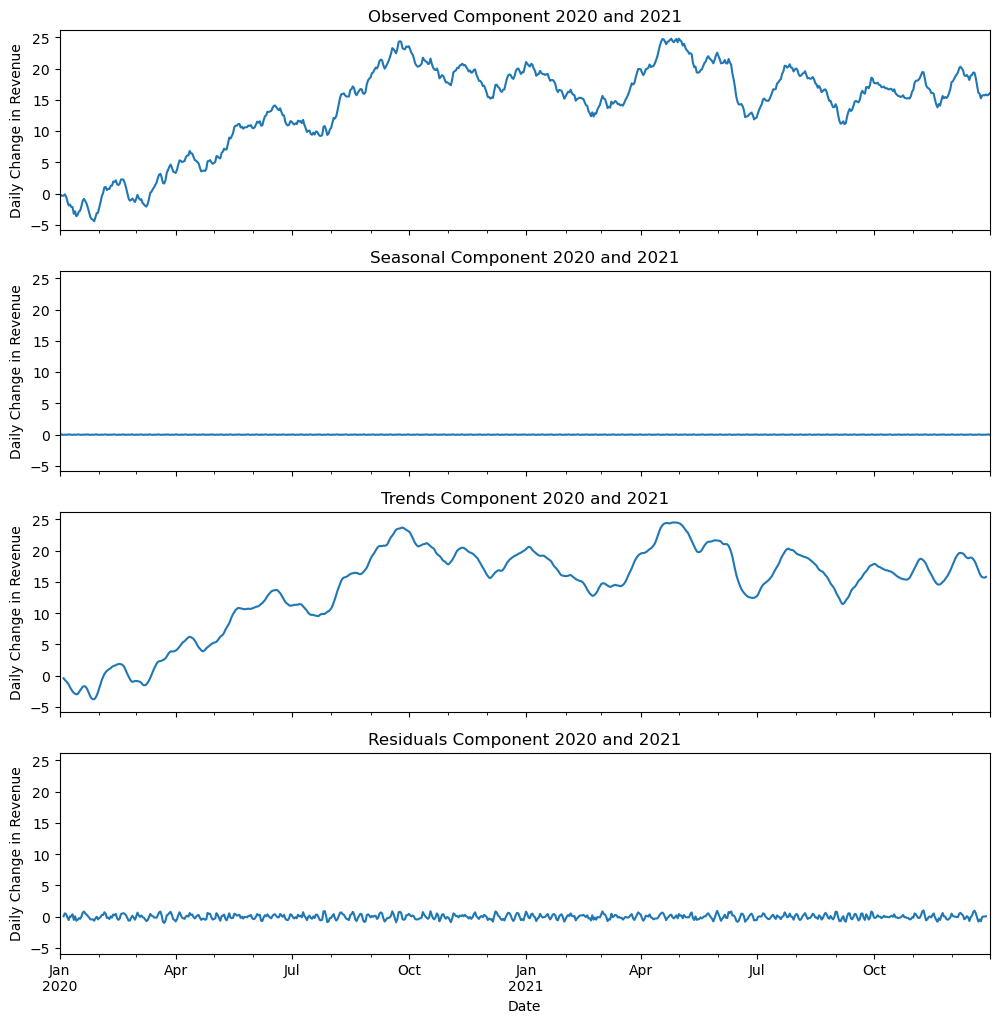

In [14]:
# Break Decomp into separate parts to control plot visualization
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(12,12))

decomp_results.observed.plot(ax=ax1)
decomp_results.seasonal.plot(ax=ax2)
decomp_results.trend.plot(ax=ax3)
decomp_results.resid.plot(ax=ax4)

ax1.set_title("Observed Component 2020 and 2021")
ax2.set_title("Seasonal Component 2020 and 2021")
ax3.set_title("Trends Component 2020 and 2021")
ax4.set_title("Residuals Component 2020 and 2021")
ax1.set_ylabel("Daily Change in Revenue")
ax2.set_ylabel("Daily Change in Revenue")
ax3.set_ylabel("Daily Change in Revenue")
ax4.set_ylabel("Daily Change in Revenue")
plt.show()

### Residuals

We can see from the below plot that no trend is visible in the residual component.

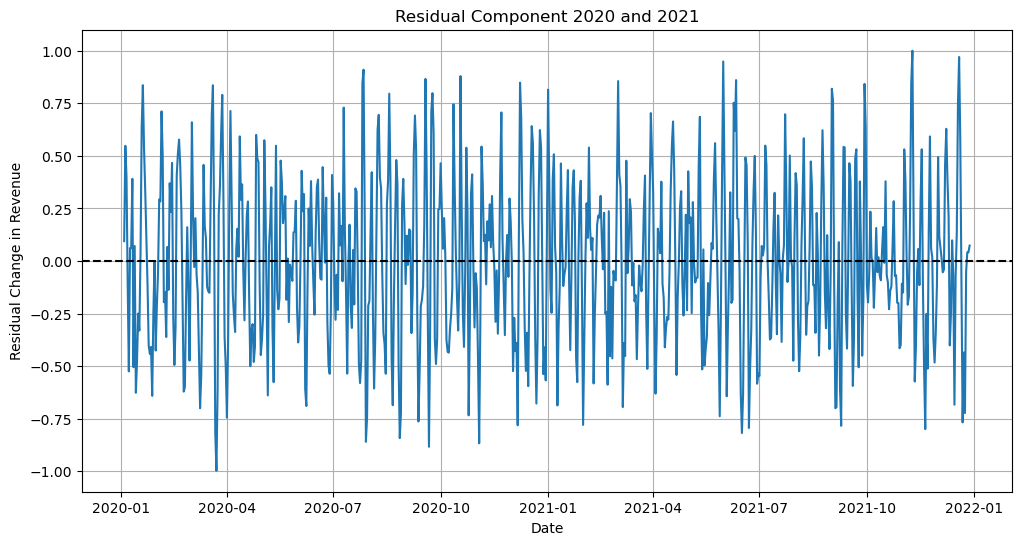

In [15]:
# Plot Residuals Component
plt.figure(figsize=(12,6))
plt.plot(decomp_results.resid)
plt.grid()
plt.axhline(0, color="black", linestyle="--")
plt.title("Residual Component 2020 and 2021")
plt.xlabel("Date")
plt.ylabel("Residual Change in Revenue")
plt.show()

# D2. ARIMA Model

Based on the previous Autocorrelation and Partial Autocorrelation I believe we have an ARIMA(1,1,0) model, but it is worth checking using auto_arima. auto_arima will loop over options until the optimal ARIMA model is found. I originally attempted to use nested for-loops for all ARIMA params, however, this was too intensive for my desktop.

In [16]:
# Get Optimal ARIMA Model from auto_arima
# will check between p 1-4, q 1-4, with a seasonal period of 7 days
# The best model will be chosen by AIC value

optimal_arima = auto_arima(df_train,
                          start_p=1,
                          start_q=1,
                          max_p=4,
                          max_q=4,
                          seasonal=True,
                          m=7,
                          information_criterion='aic',
                          error_action='ignore',
                          stepwise=True,
                          trace=True
                         )

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=676.011, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=767.498, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=672.392, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=692.554, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=766.620, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=670.883, Time=0.08 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=672.395, Time=0.24 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=674.385, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=672.407, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=672.559, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=691.444, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=671.328, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[7]             : AIC=669.349, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7]             : AIC=670.830, Time=0.09 sec
 ARIMA(1,1,0)(0,0,1)[7]             : AIC=670.8

Using auto_arima we can confirm ARIMA(1,1,0) is the optimal model. I did find it interesting the seasonal component does not show up. this matches my previous observation of how little the seasonal component magnitude was.

Again note the d value of 1 is from using the non-stationary dataset.

In [17]:
# Print Summary to get P-Value, Coeff and more
optimal_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  547
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -332.675
Date:                Sat, 30 Dec 2023   AIC                            669.349
Time:                        19:51:33   BIC                            677.955
Sample:                    01-01-2020   HQIC                           672.713
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4075      0.039     10.444      0.000       0.331       0.484
sigma2         0.1980      0.013     15.389      0.000       0.173       0.223
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 1.63
Prob(Q):                              0.76   Prob(JB):                         0.44
Heteroskedasticity (H):               1.07   Skew:                            -0.03
Prob(H) (two-sided):                  0.63   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
# Create Final Model (Remove Seasonal Component Since Not Significant)
# ARIMA object is also easier for me to predict with than suto_arima
model = ARIMA(df_train, order=(1, 1, 0))
results = model.fit()
results.summary()

C:\Users\Aaron\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Aaron\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Aaron\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  547
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -332.675
Date:                Sat, 30 Dec 2023   AIC                            669.349
Time:                        19:51:33   BIC                            677.955
Sample:                    01-01-2020   HQIC                           672.713
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4075      0.039     10.444      0.000       0.331       0.484
sigma2         0.1980      0.013     15.389      0.000       0.173       0.223
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 1.63
Prob(Q):                              0.76   Prob(JB):                         0.44
Heteroskedasticity (H):               1.07   Skew:                            -0.03
Prob(H) (two-sided):                  0.63   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## D3. Forecast

A forecast is made equal to the test data, the last half of 2021.

In [19]:
# Forecast Object Predicting Values Equal to Testing Data
forecast = results.get_prediction(
    start = len(df_train),
    end = len(df) - 1
)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

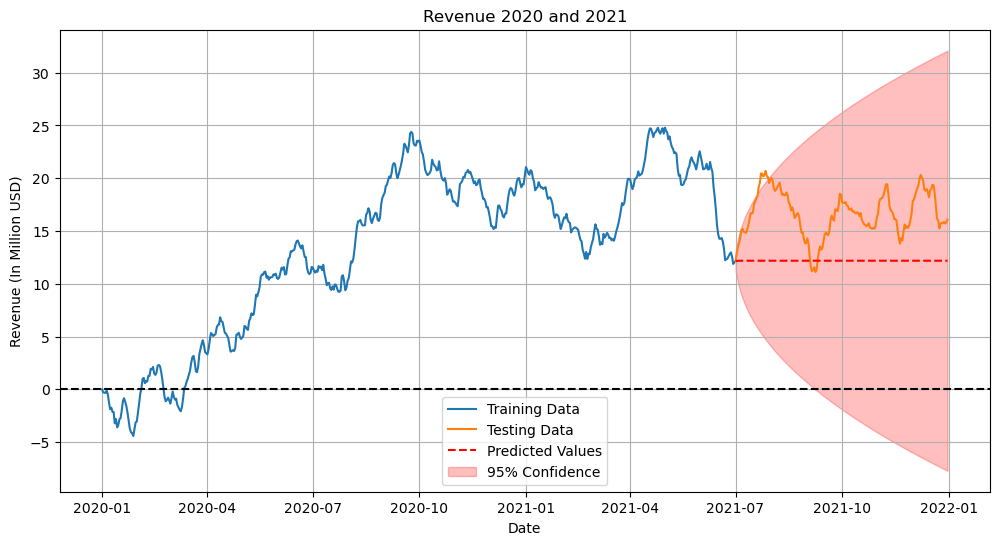

In [20]:
# Plot Train, Test, Predicted and Confidence Revenue Data
plt.figure(figsize=(12,6))
plt.plot(df_train, label="Training Data")
plt.plot(df_test, label="Testing Data")
plt.plot(mean_forecast, color='red', linestyle="--", label="Predicted Values")
plt.fill_between(
    confidence_intervals.index,
    confidence_intervals.iloc[:,0],
    confidence_intervals.iloc[:,1],
    color="red",
    alpha=0.25,
    label="95% Confidence"
)
plt.grid()
plt.axhline(0, color="black", linestyle="--")
plt.title("Revenue 2020 and 2021")
plt.xlabel("Date")
plt.ylabel(f"Revenue (In Million USD)")
plt.legend(loc='lower center')
plt.show()

### Evaluation Metrics

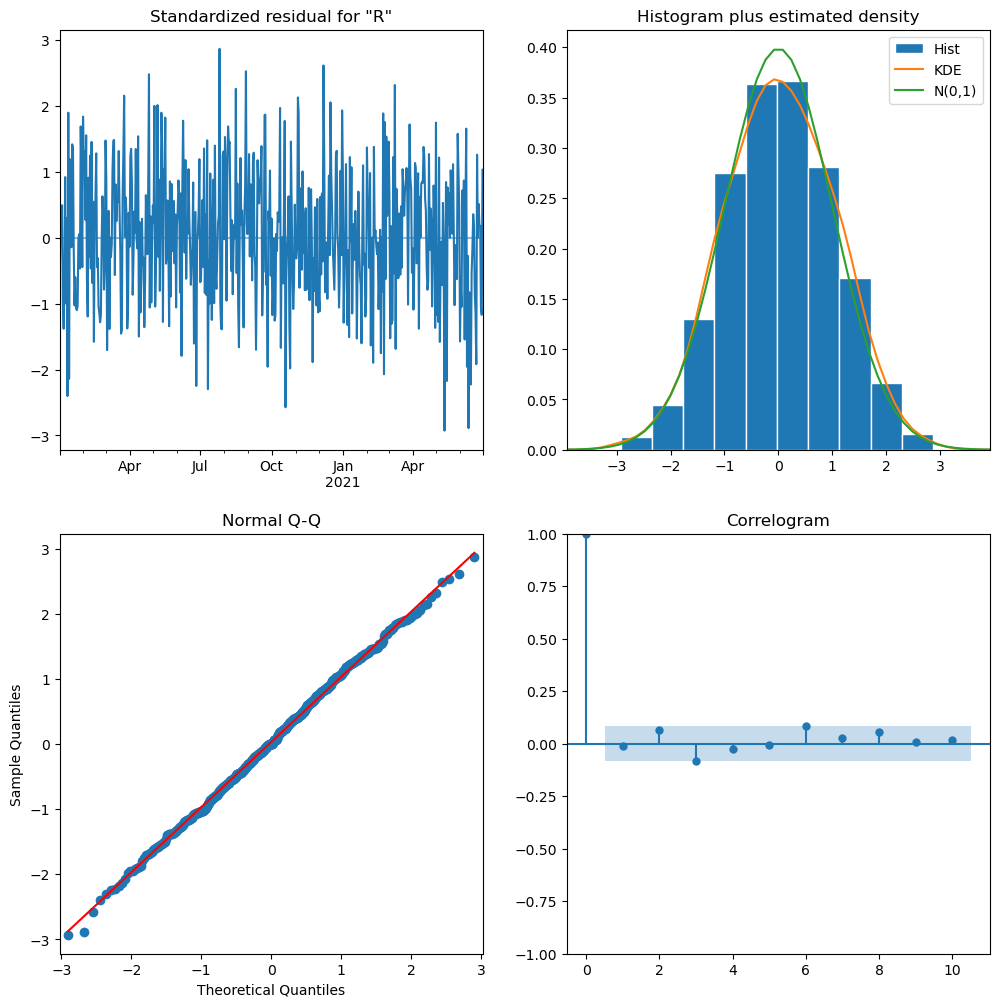

In [21]:
# Plot Model Diagnostics
results.plot_diagnostics(figsize=(12,12));

In [22]:
# Compare Predicted from Actual Test Data
# Mean Absolute Error, Mean Squared Error, Root Mean Squared Error
mae = np.mean(np.abs(results.resid))
mse = mean_squared_error(df_test, mean_forecast)
print(f'Forecasted MAE:\t\t {mae.round(4)}')
print(f'Forecasted MSE:\t\t{mse.round(4)}')
print(f'Forecasted RMSE:\t {np.sqrt(mse).round(4)}')

Forecasted MAE:		 0.3594
Forecasted MSE:		24.5313
Forecasted RMSE:	 4.9529


## D4. & D5. See Above.

## E1. Results

### ARIMA Model Selection
The ARIMA Model was selected using both the ACF/PACF method and auto_arima. ACF/PACF was more manual and required more interpretation, while the auto_arima method allowed the computer to handle most of the analysis. I believe the combination of both provided the best selection. It forced me to be involved in the data, and have the computer confirm my selection. The auto_arima method did not include a seasonal component, which matched my visual observation that the seasonal component had a very small magnitude.

### Prediction Interval & Justification of Forecast Length
I used half a year as my prediction interval since it matched my train test split. This choice was made for simplicity however, hypothetically it would also be useful for financial/business purposes. For example, at a shareholder meeting, a half year metric is more tangible than a percentage of a year or select amount of dates.

### Evaluation Procedure and Error Metric
Using plot_diagnostics() (see D2) we can confirm the model is effective:
1. no trend appears in the standardized residual
2. the estimated density almost matches the Normal Distribution
3. Normal Q-Q stays "on-line"
4. and only zero has a significant value in the Correlogram.

For the forecast, we used Mean Absolute Error, Mean Squared Error, and Root Mean Squared Error to evaluate the effectiveness. The metric we are most interested in for answering our research question is RMSE. Our goal was to have a model with an RMSE of less than 5, which would mean our root mean squared error is within 5 million dollars. The value for our model is 4.9529, which is under our analysis goal. This means we can effectively answer our research question.

## E2. Visualization

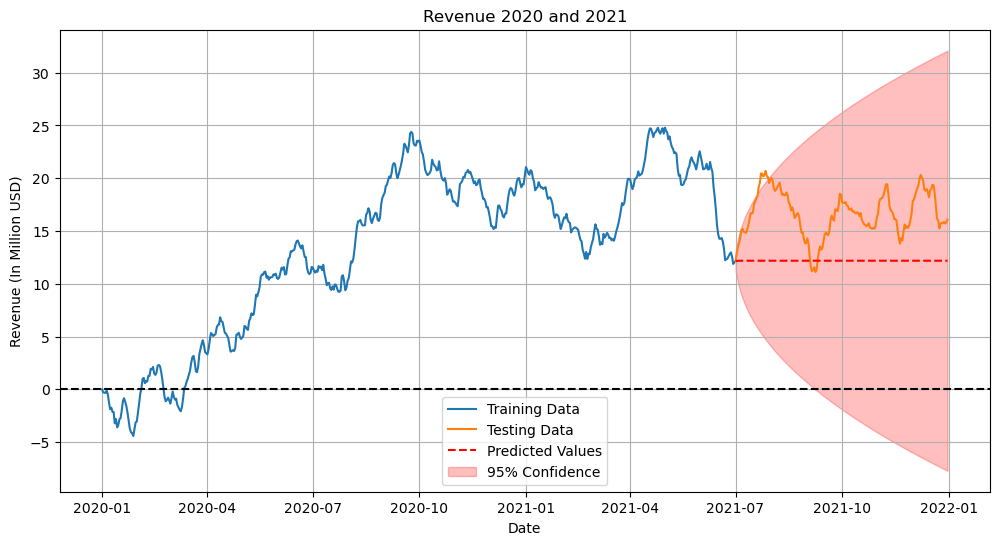

In [23]:
# Plot Train, Test, Predicted and Confidence Revenue Data
plt.figure(figsize=(12,6))
plt.plot(df_train, label="Training Data")
plt.plot(df_test, label="Testing Data")
plt.plot(mean_forecast, color='red', linestyle="--", label="Predicted Values")
plt.fill_between(
    confidence_intervals.index,
    confidence_intervals.iloc[:,0],
    confidence_intervals.iloc[:,1],
    color="red",
    alpha=0.25,
    label="95% Confidence"
)
plt.grid()
plt.axhline(0, color="black", linestyle="--")
plt.title("Revenue 2020 and 2021")
plt.xlabel("Date")
plt.ylabel(f"Revenue (In Million USD)")
plt.legend(loc='lower center')
plt.show()

## E3. Recommendation

While the model and analysis were productive, as seen by our RMSE value < 5, I have concerns about the confidence of the prediction. By the end of the predicted half-a year, the model has 95% confidence in revenue being between -8 Million and + 32 Million USD. This range is absurd for financial planning purposes. I do not believe this model can be used for long-term planning purposes, and I believe it loses its effectiveness after 1-2 months. I believe this is because of how small the training dataset was. The first six months of revenue are most likely not predictive of current revenue. 1.5 years of revenue from stable business administration would be more valuable.

I would suggest another 6 months are gathered. At that point, I would remove the first six months that are not conducive to current revenues. Then I would run the same analysis again and see if the confidence range is shallower. Until then I would not use this model for long-term financial decisions.

# Part VI: Reporting

## G. Web Sources

Reider, R. (n.d.). Time Series Analysis in Python. Datacamp. from https://app.datacamp.com/learn/courses/time-series-analysis-in-python

Vincent, T. (n.d.). Visualizing Time Series Data in Python. Datacamp. from https://app.datacamp.com/learn/courses/visualizing-time-series-data-in-python

Fulton, J. (n.d.). ARIMA Models in Python. Datacamp. from https://app.datacamp.com/learn/courses/arima-models-in-python

Python Pandas DateOffset using value from another column. (n.d.). Stack Overflow. Retrieved December 30, 2023, from https://stackoverflow.com/questions/23917144/python-pandas-dateoffset-using-value-from-another-column

statsmodels.graphics.tsaplots.plot_acf - statsmodels 0.14.0. (n.d.). Www.statsmodels.org. https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html

matplotlib.pyplot.psd — Matplotlib 3.8.2 documentation. (n.d.). Matplotlib.org. Retrieved December 30, 2023, from https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.psd.html

Chugh, A. (2020, December 8). MAE, MSE, RMSE, Coefficient of Determination, Adjusted R Squared — Which Metric is Better? Medium. https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e

pmdarima.arima.auto_arima — pmdarima 1.5.3 documentation. (n.d.). Alkaline-Ml.com. https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

## H. Other Sources

Statistics Solutions. (2023). Assumptions of Linear Regression. Statistics Solutions. https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/assumptions-of-linear-regression/
